Color image LOD2 shape: (2048, 2048, 3)Color image LOD1 shape: (2048, 2048, 3)


(np.float64(-0.5), np.float64(2047.5), np.float64(2047.5), np.float64(-0.5))

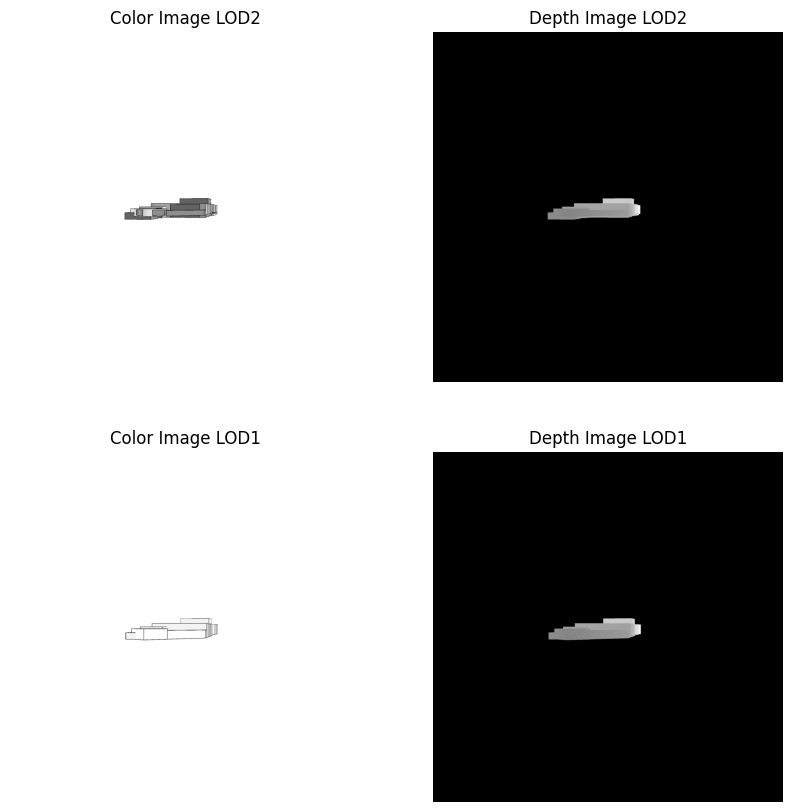

In [8]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# load an example of canny image from 
DATASET_DIR = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth"

example_color_image_lod2 = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth/image/0/lod2/lod2_az010_el00.png"
example_color_image_lod1 = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth/image/0/lod1/lod1_az010_el00.png"

example_depth_image_lod2 = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth/depth/0/lod2/lod2_az010_el00.png"
example_depth_image_lod1 = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth/depth/0/lod1/lod1_az010_el00.png"


# Load the color image
color_image_lod2 = cv2.imread(example_color_image_lod2, cv2.IMREAD_UNCHANGED)
color_image_lod1 = cv2.imread(example_color_image_lod1, cv2.IMREAD_UNCHANGED)

print(f"Color image LOD2 shape: {color_image_lod2.shape}"
      f"Color image LOD1 shape: {color_image_lod1.shape}")

# load the depth image
depth_image_lod2 = cv2.imread(example_depth_image_lod2, cv2.IMREAD_GRAYSCALE)
depth_image_lod1 = cv2.imread(example_depth_image_lod1, cv2.IMREAD_GRAYSCALE) 

# plot as grid (0,0) is color lod2, (0,1) is depth lod2, (1,0) is color lod1, (1,1) is depth lod1
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(cv2.cvtColor(color_image_lod2, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Color Image LOD2')
axs[0, 0].axis('off')
axs[0, 1].imshow(depth_image_lod2, cmap='gray')
axs[0, 1].set_title('Depth Image LOD2')
axs[0, 1].axis('off')
axs[1, 0].imshow(cv2.cvtColor(color_image_lod1, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Color Image LOD1')
axs[1, 0].axis('off')
axs[1, 1].imshow(depth_image_lod1, cmap='gray')
axs[1, 1].set_title('Depth Image LOD1')
axs[1, 1].axis('off')   


## Crop and save

In [1]:
import os
import cv2
import numpy as np

# Configuration
dataset_root = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth"
image_root   = os.path.join(dataset_root, "image")
depth_root   = os.path.join(dataset_root, "depth")
output_root  = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth_cropped_512x512"
margin       = 1.05  # margin for cropping

# Create output directories
for sub in ["image", "depth"]:
    for scene in range(51):
        for lod in ["lod1", "lod2"]:
            out_dir = os.path.join(output_root, sub, str(scene), lod)
            os.makedirs(out_dir, exist_ok=True)

# Process each scene and view (example: scene 0 only)
for scene in range(0, 1):
    scene_str = str(scene)
    img1_dir  = os.path.join(image_root, scene_str, "lod1")
    img2_dir  = os.path.join(image_root, scene_str, "lod2")
    dep1_dir  = os.path.join(depth_root, scene_str, "lod1")
    dep2_dir  = os.path.join(depth_root, scene_str, "lod2")

    if not (os.path.isdir(img1_dir) and os.path.isdir(img2_dir)):
        continue

    for fname1 in os.listdir(img1_dir):
        if not fname1.endswith(".png"):
            continue

        # derive lod2 filename
        # fname1 = "lod1_az010_el00.png" → suffix = "az010_el00.png"
        suffix = fname1[len("lod1_"):]
        fname2 = "lod2_" + suffix  # "lod2_az010_el00.png"

        path1_img = os.path.join(img1_dir, fname1)
        path2_img = os.path.join(img2_dir, fname2)
        path1_dep = os.path.join(dep1_dir, fname1)
        path2_dep = os.path.join(dep2_dir, fname2)

        # skip pair if any file is missing
        if not (os.path.isfile(path2_img) and os.path.isfile(path1_dep) and os.path.isfile(path2_dep)):
            continue

        # load
        img1 = cv2.imread(path1_img, cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread(path2_img, cv2.IMREAD_UNCHANGED)
        dep1 = cv2.imread(path1_dep, cv2.IMREAD_UNCHANGED)
        dep2 = cv2.imread(path2_dep, cv2.IMREAD_UNCHANGED)

        # mask of non-white pixels (works for both color & depth if 3-channel)
        mask1 = np.any(img1 < 255, axis=2)
        mask2 = np.any(img2 < 255, axis=2)
        mask  = mask1 | mask2

        ys, xs = np.where(mask)
        if ys.size == 0:
            continue

        # raw bbox
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        h, w         = (y_max - y_min), (x_max - x_min)

        # square size with margin
        size0 = max(h, w)
        size  = int(np.ceil(size0 * margin))

        # center
        y_c = (y_min + y_max) // 2
        x_c = (x_min + x_max) // 2

        # new coords
        y0 = y_c - size // 2
        x0 = x_c - size // 2
        y1 = y0 + size
        x1 = x0 + size

        # clamp into image bounds
        H, W = img1.shape[:2]
        if y0 < 0:
            y1 += -y0
            y0  = 0
        if x0 < 0:
            x1 += -x0
            x0  = 0
        if y1 > H:
            y0 -= (y1 - H)
            y1  = H
        if x1 > W:
            x0 -= (x1 - W)
            x1  = W
        y0, x0 = max(0, y0), max(0, x0)

        # crop + resize
        crop_img1 = cv2.resize(img1[y0:y1, x0:x1], (512,512), interpolation=cv2.INTER_AREA)
        crop_img2 = cv2.resize(img2[y0:y1, x0:x1], (512,512), interpolation=cv2.INTER_AREA)
        crop_dep1 = cv2.resize(dep1[y0:y1, x0:x1], (512,512), interpolation=cv2.INTER_NEAREST)
        crop_dep2 = cv2.resize(dep2[y0:y1, x0:x1], (512,512), interpolation=cv2.INTER_NEAREST)

        # Save with matching names
        cv2.imwrite(os.path.join(output_root, "image", scene_str, "lod1", fname1), crop_img1)
        cv2.imwrite(os.path.join(output_root, "image", scene_str, "lod2", fname2), crop_img2)
        cv2.imwrite(os.path.join(output_root, "depth", scene_str, "lod1", fname1), crop_dep1)
        cv2.imwrite(os.path.join(output_root, "depth", scene_str, "lod2", fname2), crop_dep2)

print("Preprocessing complete: cropped and resized to 512×512 with margin.")


Preprocessing complete: cropped and resized to 512×512 with margin.


## LOD to Canny edges

In [10]:
import os
import cv2
import numpy as np

# Configuration
root = "/home/athiwat/progressive_img2sketch/resources/LOD50_opaque_normalized_1radius_triangulated_fix_normals_orbits_with_depth_cropped_512x512"
image_root = os.path.join(root, "image")
LOW_THRESHOLD = 100
HIGH_THRESHOLD = 150
EDGE_METHOD = "log"  # Options: "canny", "log", "xdog"

# Output base
out_sub = {"canny": "canny", "log": "log", "xdog": "xdog"}[EDGE_METHOD]

# Create output directories
for sub in [out_sub, "sketch"]:
    for scene in range(51):
        for lod in ["lod1", "lod2"]:
            out_dir = os.path.join(root, sub, str(scene), lod)
            os.makedirs(out_dir, exist_ok=True)

# xDoG function
def xdog(gray, k=1.6, sigma=0.8, epsilon=-0.1, phi=10.0):
    gray = gray.astype(np.float32) / 255.0
    blur1 = cv2.GaussianBlur(gray, (0, 0), sigma)
    blur2 = cv2.GaussianBlur(gray, (0, 0), sigma * k)
    dog = blur1 - blur2
    dog /= np.max(np.abs(dog)) + 1e-8
    edge = np.ones_like(dog)
    edge[dog < epsilon] = 1.0
    edge[dog >= epsilon] = 1 + np.tanh(phi * (dog[dog >= epsilon] - epsilon))
    return (edge * 255).astype(np.uint8)

# Process each scene and view
for scene in range(0, 1):  # Change this to range(51) to do all scenes
    scene_str = str(scene)
    img1_dir = os.path.join(image_root, scene_str, "lod1")
    img2_dir = os.path.join(image_root, scene_str, "lod2")

    if not (os.path.isdir(img1_dir) and os.path.isdir(img2_dir)):
        continue

    for fname1 in os.listdir(img1_dir):
        if not fname1.endswith(".png"):
            continue

        suffix = fname1[len("lod1_"):]
        fname2 = "lod2_" + suffix

        path1_img = os.path.join(img1_dir, fname1)
        path2_img = os.path.join(img2_dir, fname2)

        if not (os.path.isfile(path2_img) and os.path.isfile(path1_img)):
            continue

        img1 = cv2.imread(path1_img, cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread(path2_img, cv2.IMREAD_UNCHANGED)

        gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        if EDGE_METHOD == "canny":
            blur1 = cv2.GaussianBlur(gray_img1, (9, 9), 0)
            blur2 = cv2.GaussianBlur(gray_img2, (9, 9), 0)
            edge1 = cv2.Canny(blur1, LOW_THRESHOLD, HIGH_THRESHOLD)
            edge2 = cv2.Canny(blur2, LOW_THRESHOLD, HIGH_THRESHOLD)

        elif EDGE_METHOD == "log":
            blur1 = cv2.GaussianBlur(gray_img1, (5, 5), 0)
            blur2 = cv2.GaussianBlur(gray_img2, (5, 5), 0)
            lap1 = cv2.Laplacian(blur1, cv2.CV_8U)
            lap2 = cv2.Laplacian(blur2, cv2.CV_8U)

            # Bias amount (lower threshold → more black)
            bias = 10

            # Otsu threshold, then subtract bias (clip to ≥0)
            t1, _ = cv2.threshold(lap1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            t2, _ = cv2.threshold(lap2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            biased_t1 = max(t1 - bias, 0)
            biased_t2 = max(t2 - bias, 0)

            # Apply inverted binary threshold with biased value
            _, edge1 = cv2.threshold(lap1, biased_t1, 255, cv2.THRESH_BINARY_INV)
            _, edge2 = cv2.threshold(lap2, biased_t2, 255, cv2.THRESH_BINARY_INV)


        else:
            raise ValueError(f"Unsupported EDGE_METHOD: {EDGE_METHOD}")

        # Invert for sketch effect
        sketch_img1 = cv2.bitwise_not(edge1)
        sketch_img2 = cv2.bitwise_not(edge2)

        # Save
        cv2.imwrite(os.path.join(root, out_sub, scene_str, "lod1", fname1), edge1)
        cv2.imwrite(os.path.join(root, out_sub, scene_str, "lod2", fname2), edge2)
        cv2.imwrite(os.path.join(root, "sketch", scene_str, "lod1", fname1), sketch_img1)
        cv2.imwrite(os.path.join(root, "sketch", scene_str, "lod2", fname2), sketch_img2)

print(f"Done. Extracted edges using method: {EDGE_METHOD}")


Done. Extracted edges using method: log
